In [69]:
import pandas as pd
import plotly.express as px
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [70]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [71]:
df_train

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,NaN,0.0,0.0,1000.00,1000.0,0.0,1.0
35340,35538,40372,1380,2019-12-30,NaN,0.0,0.0,2000.00,2000.0,0.0,1.0
35341,35539,40373,1380,2019-12-30,NaN,0.0,0.0,3000.00,3000.0,0.0,1.0
35342,35540,46272,1380,2019-12-30,NaN,1.0,0.0,284.29,199.0,0.0,1.0


In [72]:
for column in df_train.columns:
    if len(df_train[column].unique()) < 10:
        print(column, df_train[column].unique())

product_rk [40369 40370 40372 40373 46272 96212]
PROMO1_FLAG [nan  1.  0.  2.]
PROMO2_FLAG [nan  0.]
NUM_CONSULTANT [nan  0.]
AUTORIZATION_FLAG [nan  1.  0.]


In [73]:
def clear_train(df_train, df_test):
    def fill_with_mode(series):
        mode = series.mode()
        if not mode.empty:
            return series.fillna(mode.iloc[0])
        return series
    df_train_impl = df_train.copy()
    df_train_impl = df_train_impl.drop(["NUM_CONSULTANT", "PROMO2_FLAG"], axis = 1)
    df_train_impl = df_train_impl.dropna(subset=['demand'])
    # df_train_impl = df_train_impl.dropna()
    #
    df_train_impl['period_start_dt'] = pd.to_datetime(df_train_impl['period_start_dt'], format= "%Y-%m-%d")
    df_train_impl = df_train_impl.rename(columns = {"Unnamed: 0": "id"})
    info_test = set()
    for _, row in df_test.iterrows():
        info_test.add(str(int(row.product_rk)) + " " + str(int(row.store_location_rk)))
    info_train = set()
    for index, row in df_train_impl.iterrows():
        info_train.add(str(int(row.product_rk)) + " " + str(int(row.store_location_rk)))
    for elem in info_train ^ info_test:
        elem1, elem2 = map(int, elem.split(" "))
        df_train_impl = df_train_impl[~((df_train_impl['product_rk'] == elem1) & (df_train_impl['store_location_rk'] == elem2))]
    spec_columns = ["PROMO1_FLAG", "PRICE_REGULAR", "PRICE_AFTER_DISC", "AUTORIZATION_FLAG"]
    # for column in spec_columns:
    #     df_train_impl[column] = df_train_impl.groupby(['product_rk', 'store_location_rk'])[column].transform(fill_with_mode)
    df_train_impl["monthday"] = df_train_impl.period_start_dt.dt.day
    return df_train_impl

In [74]:
df_train_clear = clear_train(df_train, df_test)

In [75]:
df_train_clear

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday
15,15,40369,317,2016-12-19,50.0,NaN,NaN,NaN,NaN,19
16,16,40370,317,2016-12-19,44.0,NaN,NaN,NaN,NaN,19
17,17,40372,317,2016-12-19,13.0,NaN,NaN,NaN,NaN,19
18,18,40373,317,2016-12-19,6.0,NaN,NaN,NaN,NaN,19
19,19,46272,317,2016-12-19,34.0,NaN,NaN,NaN,NaN,19
...,...,...,...,...,...,...,...,...,...,...
35309,35507,40370,1380,2019-11-25,24.0,0.0,1000.000000,1000.000000,1.0,25
35310,35508,40372,1380,2019-11-25,11.0,0.0,2000.000000,2000.000000,1.0,25
35311,35509,40373,1380,2019-11-25,3.0,0.0,3000.000000,3000.000000,1.0,25
35312,35510,46272,1380,2019-11-25,0.0,1.0,284.290000,199.000000,1.0,25


In [76]:
from ipywidgets import IntProgress
from copy import deepcopy
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col, freq = None, default_value = np.NaN):

    if freq is None:
        try:
           freq = pd.infer_freq(x.set_index(date_col).index[:min(100, x.shape[0])])
        except:
           freq = 'D'

        if freq is None:
          freq = 'D'
          Warning('TS freq is not defined! Daily granularity is provided!')
    # print(freq)
    # new indexes without time breaks
    idx = pd.date_range(x[date_col].min(), x[date_col].max(), freq=freq)
    # print(idx)
    results = x.set_index(date_col).reindex(idx,fill_value = default_value)
    results.index.rename(date_col, inplace = True)

    # groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    # results = groupby_day.sum(min_count=1)

    # idx = pd.period_range(min_date, max_date)
    # results = results.reindex(idx, fill_value=default_value)

    # results.index.rename(date_col, inplace=True)

    return results.reset_index()


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
         fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                     axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag # ,  data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1).reset_index(group_col)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled

# ewma calculation method
def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1).reset_index(group_col)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled

# shift ts data
def shift(lf_df_filled, group_col, date_col, lag, kwargs = None):

    lf_df = (lf_df_filled.     # prepare calculations
        set_index(date_col).    # date column as time-index
        groupby(group_col[:-1]).       # ids_col to separate different time series
        apply(lambda x: x.shift(lag, kwargs)).    # aplly shift at lag steps
        drop(group_col[:-1], axis=1).                   # drop ids_col from time df to reset index
        reset_index()              # reset index to return df to no-index state
    )
    # lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))
    # print(lf_df.index)

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

    '''
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for preagg in preagg_methods:
          data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                  target_cols, preagg)

          ## add ewm features
          for alpha in ewm_params.get(filter_col, []):
              ewm_filled = calc_ewm(data_preag_filled, group_col,
                                    date_col, alpha)
              for lag in lags:
                ewm = shift(ewm_filled, group_col, date_col, lag)

                new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                    format(x, lag, alpha, '&'.join(id_cols), preagg, filter_col) for x in target_cols}

                out_df = pd.merge(out_df,
                                  ewm.rename(columns=new_names),
                                  how='left',
                                  on=group_col)

          ## add rolling features
          for w in windows:
              for method in agg_methods:
                  rolling_filled = calc_rolling(data_preag_filled,
                                                group_col, date_col,
                                                method, w)
                  for lag in lags:
                    ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                    rolling = shift(rolling_filled, group_col, date_col, lag)

                    method_name = method.__name__ if type(
                        method) != str else method

                    new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                  format(x, lag, w, '&'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      rolling.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                    progress.value += 1

    return out_df

In [77]:
df_new = df_train_clear.drop(columns = ["id"])

result_df = generate_lagged_features(
    data=df_new,
    target_cols=['demand'],
    id_cols=['product_rk', 'store_location_rk'],
    date_col='period_start_dt',
    lags=[49, 56, 63, 70, 77, 84, 91],
    windows=['7D', '14D', '21D', '28D', '35D', '42D'],
    preagg_methods=['mean'],
    agg_methods=['mean', 'median', percentile(10), pd.Series.skew],
    dynamic_filters=['PROMO1_FLAG', 'AUTORIZATION_FLAG'],
    ewm_params={'PROMO1_FLAG': [14, 21, 28, 35,41,49, 56, 63], 'AUTORIZATION_FLAG': [14, 21, 28, 35,41,49, 56, 63]}
)

IntProgress(value=0, max=336)

In [78]:
result_df

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday,demand_lag49d_alpha14_keyproduct_rk&store_location_rk_preagmean_PROMO1_FLAG_dynamic_ewm,...,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag49d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag56d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag63d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag70d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling
0,40369,317,2016-12-19,50.0,NaN,NaN,NaN,NaN,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40369,1034,2016-12-19,20.0,NaN,NaN,NaN,NaN,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40370,1034,2016-12-19,31.0,NaN,NaN,NaN,NaN,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40372,1034,2016-12-19,11.0,NaN,NaN,NaN,NaN,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40373,1034,2016-12-19,14.0,NaN,NaN,NaN,NaN,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34124,96212,1326,2019-11-25,0.0,1.0,99.000000,69.300000,1.0,25,2.429817,...,0.0,1.0,0.0,1.095405,0.418072,1.585618,0.280825,1.053933,-0.276941,0.145913
34125,46272,1326,2019-11-25,2.0,1.0,284.290000,199.000000,1.0,25,3.045658,...,0.5,0.5,0.5,0.693869,1.263725,1.358386,1.375849,0.794947,0.888766,1.079226
34126,40373,1326,2019-11-25,5.0,0.0,3000.000000,3000.000000,1.0,25,10.604454,...,4.5,5.0,9.5,1.436941,0.812415,0.330232,-0.784966,0.366465,-0.052951,0.462910
34127,40372,555,2019-11-25,18.0,0.0,2000.000000,2000.000000,1.0,25,7.207413,...,2.5,2.0,4.0,0.691938,1.194960,0.000000,-0.052951,-0.918630,-0.888766,-1.178668


In [79]:
result_df.set_index('period_start_dt', inplace = True)

In [80]:
from sklearn.model_selection import train_test_split

X = result_df.drop(['store_location_rk','product_rk', 'demand'], axis=1)
y = result_df.demand
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
!pip install lightgbm
import lightgbm as lgb
# kwargs={'verbose':2}

def plot_feature_importance(model, X , num = 20):
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set_style("darkgrid")
  sns.mpl.rc("figure", figsize=(25, 5))
  sns.mpl.rc("font", size=14)

  feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                      ascending=False)[0:num])
  plt.title('LightGBM Features (avg over folds)')
  # plt.tight_layout()
  # plt.savefig('lgbm_importances-01.png')
  plt.show()

In [82]:
!pip install optuna

In [83]:
import optuna
import logging
from utils import qualityWAPE, qualitySMAPE
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

def objective_lgb(trial):
    import numpy as np
    import lightgbm as lgb

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "random_state": 42,
        "verbose": -1
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return qualitySMAPE(y_valid, preds)[0]

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=50)
print("Лучшие гиперпараметры:", study_lgb.best_params)
print("Лучшее SMAPE:", study_lgb.best_value)


[I 2025-02-22 20:03:49,805] A new study created in memory with name: no-name-3aeb28cc-9259-42b0-9893-aff9a49d4284
[I 2025-02-22 20:04:22,804] Trial 0 finished with value: 0.7248741356376917 and parameters: {'n_estimators': 408, 'learning_rate': 0.028095591731270707, 'max_depth': 3}. Best is trial 0 with value: 0.7248741356376917.
[I 2025-02-22 20:06:57,128] Trial 1 finished with value: 0.6822441586308219 and parameters: {'n_estimators': 1417, 'learning_rate': 0.21722924302197413, 'max_depth': 7}. Best is trial 1 with value: 0.6822441586308219.
[I 2025-02-22 20:10:48,458] Trial 2 finished with value: 0.6742809841687715 and parameters: {'n_estimators': 1814, 'learning_rate': 0.05975806240614993, 'max_depth': 10}. Best is trial 2 with value: 0.6742809841687715.
[I 2025-02-22 20:13:09,330] Trial 3 finished with value: 0.7105062434559883 and parameters: {'n_estimators': 1453, 'learning_rate': 0.2037999196409646, 'max_depth': 6}. Best is trial 2 with value: 0.6742809841687715.
[I 2025-02-22 

Лучшие гиперпараметры: {'n_estimators': 661, 'learning_rate': 0.045065108074739416, 'max_depth': 5}
Лучшее SMAPE: 0.3693856264978775


Запомнили {'n_estimators': 1901, 'learning_rate': 0.23296966354291979, 'max_depth': 7}

{'n_estimators': 1880, 'learning_rate': 0.19319195669195374, 'max_depth': 3}

In [84]:
best_params = {'n_estimators': 1901, 'learning_rate': 0.23296966354291979, 'max_depth': 7}

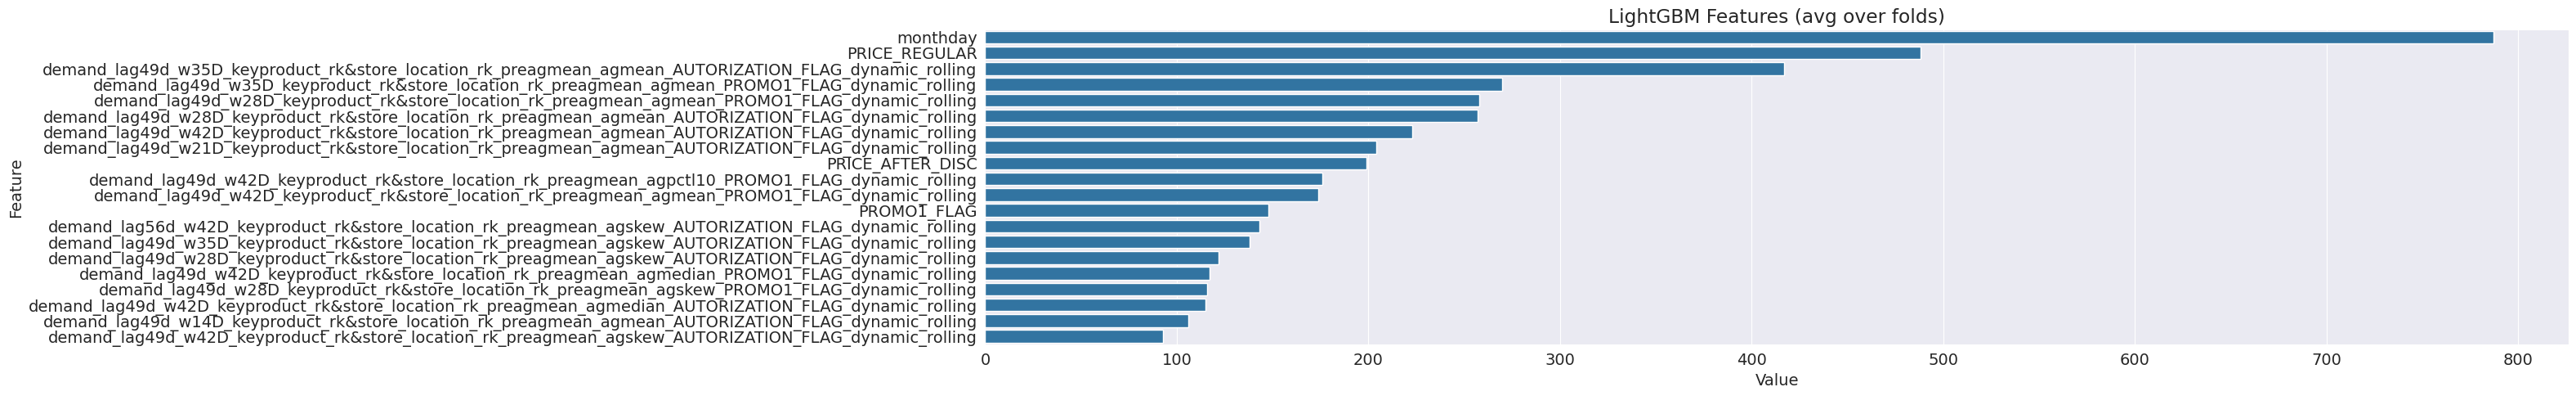

In [85]:
lgbm1 = lgb.LGBMRegressor(**study_lgb.best_params)
lgbm1.fit(result_df.drop(['store_location_rk','product_rk', 'demand'], axis = 1), result_df.demand)
plot_feature_importance(lgbm1, result_df.drop(['store_location_rk','product_rk', 'demand'], axis = 1), num = 20)

In [86]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from utils import qualityWAPE, qualitySMAPE

y_pred = lgbm1.predict(result_df.drop(['store_location_rk','product_rk', 'demand'], axis=1))

mae = mean_absolute_error(result_df.demand, y_pred)
r2_score = r2_score(result_df.demand, y_pred)
mse = mean_squared_error(result_df.demand, y_pred)
print("root mean_squared_error:", mse**0.5)
print("Mean Absolute Error (MAE):", mae)
print("r2_score:", r2_score)
print("qualityWAPE", qualityWAPE(result_df.demand, y_pred)[0])
print("SMAPE", qualitySMAPE(result_df.demand, y_pred)[0])

root mean_squared_error: 19.6669744507833
Mean Absolute Error (MAE): 6.89178826180598
r2_score: 0.6357100295247441
qualityWAPE 0.5636739080895555
SMAPE 0.6572292256219554


In [87]:
unique_pairs = df_train_clear[['product_rk', 'store_location_rk']].drop_duplicates()

forecast_weeks = 6
forecast_rows = []
for _, pair in unique_pairs.iterrows():
    product = pair['product_rk']
    store = pair['store_location_rk']
    df_pair = df_train_clear[(df_train_clear['product_rk'] == product) &
                             (df_train_clear['store_location_rk'] == store)]
    last_date = pd.to_datetime(df_pair['period_start_dt']).max()
    future_dates = [last_date + pd.Timedelta(days=7 * i) for i in range(1, forecast_weeks + 1)]
    median_PROMO1_FLAG = df_pair['PROMO1_FLAG'].median()
    median_PRICE_REGULAR = df_pair['PRICE_REGULAR'].median()
    median_PRICE_AFTER_DISC = df_pair['PRICE_AFTER_DISC'].median()
    median_AUTORIZATION_FLAG = df_pair['AUTORIZATION_FLAG'].median()
    for dt in future_dates:
        forecast_rows.append({
            'id': 0,
            'product_rk': product,
            'store_location_rk': store,
            'period_start_dt': dt,
            'demand': np.nan,
            'PROMO1_FLAG': median_PROMO1_FLAG,
            'PRICE_REGULAR': median_PRICE_REGULAR,
            'PRICE_AFTER_DISC': median_PRICE_AFTER_DISC,
            'AUTORIZATION_FLAG': median_AUTORIZATION_FLAG,
            'monthday': dt.day
        })

forecast_df = pd.DataFrame(forecast_rows)
forecast_df.sort_values(['product_rk', 'store_location_rk', 'period_start_dt'], inplace=True)
forecast_df.reset_index(drop=True, inplace=True)

forecast_df

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday
0,0,40369,317,2019-12-02,NaN,0.0,500.0,500.000000,1.0,2
1,0,40369,317,2019-12-09,NaN,0.0,500.0,500.000000,1.0,9
2,0,40369,317,2019-12-16,NaN,0.0,500.0,500.000000,1.0,16
3,0,40369,317,2019-12-23,NaN,0.0,500.0,500.000000,1.0,23
4,0,40369,317,2019-12-30,NaN,0.0,500.0,500.000000,1.0,30
...,...,...,...,...,...,...,...,...,...,...
1435,0,96212,1380,2019-12-09,NaN,1.0,99.0,65.982857,1.0,9
1436,0,96212,1380,2019-12-16,NaN,1.0,99.0,65.982857,1.0,16
1437,0,96212,1380,2019-12-23,NaN,1.0,99.0,65.982857,1.0,23
1438,0,96212,1380,2019-12-30,NaN,1.0,99.0,65.982857,1.0,30


In [88]:
df_train_clear.index = df_train_clear.index.astype(int)
df_train_test_for_predict = pd.concat([df_train_clear, forecast_df], axis = 0)
df_train_test_for_predict

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday
15,15,40369,317,2016-12-19,50.0,NaN,NaN,NaN,NaN,19
16,16,40370,317,2016-12-19,44.0,NaN,NaN,NaN,NaN,19
17,17,40372,317,2016-12-19,13.0,NaN,NaN,NaN,NaN,19
18,18,40373,317,2016-12-19,6.0,NaN,NaN,NaN,NaN,19
19,19,46272,317,2016-12-19,34.0,NaN,NaN,NaN,NaN,19
...,...,...,...,...,...,...,...,...,...,...
1435,0,96212,1380,2019-12-09,NaN,1.0,99.0,65.982857,1.0,9
1436,0,96212,1380,2019-12-16,NaN,1.0,99.0,65.982857,1.0,16
1437,0,96212,1380,2019-12-23,NaN,1.0,99.0,65.982857,1.0,23
1438,0,96212,1380,2019-12-30,NaN,1.0,99.0,65.982857,1.0,30


In [89]:
result_df_train_test = generate_lagged_features(
    data=df_train_test_for_predict,
    target_cols=['demand'],
    id_cols=['product_rk', 'store_location_rk'],
    date_col='period_start_dt',
    lags=[49, 56, 63, 70, 77, 84, 91],
    windows=['7D', '14D', '21D', '28D', '35D', '42D'],
    preagg_methods=['mean'],
    agg_methods=['mean', 'median', percentile(10), pd.Series.skew],
    dynamic_filters=['PROMO1_FLAG', 'AUTORIZATION_FLAG'],
    ewm_params={'PROMO1_FLAG': [14, 21, 28, 35,41,49, 56, 63], 'AUTORIZATION_FLAG': [14, 21, 28, 35,41,49, 56, 63]}
)
result_df_train_test.columns

IntProgress(value=0, max=336)

Index(['id', 'product_rk', 'store_location_rk', 'period_start_dt', 'demand',
       'PROMO1_FLAG', 'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'AUTORIZATION_FLAG',
       'monthday',
       ...
       'demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag49d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag56d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag63d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag70d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling',
       'demand_lag77d_w

In [90]:
result_df_train_test

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday,...,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag49d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag56d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag63d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag70d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling
0,15,40369,317,2016-12-19,50.0,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19510,40370,874,2016-12-19,84.0,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19511,40372,874,2016-12-19,19.0,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19512,40373,874,2016-12-19,6.0,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19513,46272,874,2016-12-19,26.0,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35564,0,40372,866,2020-01-06,NaN,0.0,2000.000000,2000.000000,1.0,6,...,3.0,2.000000,3.0,1.102999,-0.807476,0.958670,1.214388,-0.888766,1.098317,2.428053
35565,0,40372,874,2020-01-06,NaN,0.0,2000.000000,2000.000000,1.0,6,...,5.0,3.289618,0.0,0.610282,2.449490,0.024104,2.250000,0.624294,0.955188,2.414333
35566,0,46272,1363,2020-01-06,NaN,1.0,239.000000,190.000000,1.0,6,...,5.0,2.000000,3.0,2.241548,2.131097,1.502919,1.009703,0.570441,-0.205532,1.914501
35567,0,96212,317,2020-01-06,NaN,1.0,84.714286,49.500000,1.0,6,...,5.9,4.764706,4.0,2.009120,1.628637,0.944573,-0.186339,1.367253,-0.960848,0.000000


In [91]:
if ("id" in result_df_train_test.columns):
    result_df_train_test = result_df_train_test.drop("id", axis = 1)
if ("period_start_dt" in result_df_train_test.columns):
    result_df_train_test.set_index('period_start_dt', inplace = True)
result_without_nan = result_df_train_test[result_df_train_test['demand'].isna() == False]
result_with_nan = result_df_train_test[result_df_train_test['demand'].isna() == True]

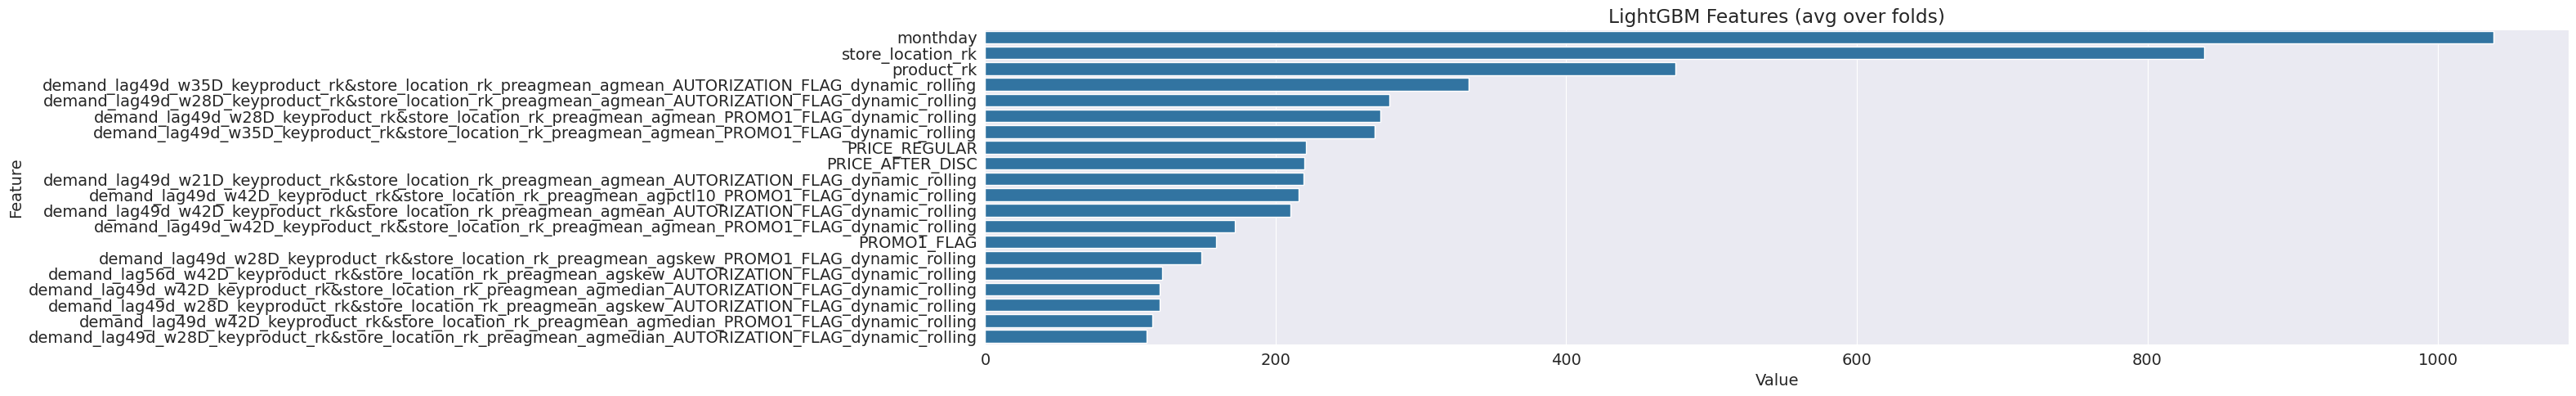

In [92]:
lgbm1 = lgb.LGBMRegressor(**study_lgb.best_params)
lgbm1.fit(result_without_nan.drop(['demand'], axis = 1), result_without_nan.demand)
plot_feature_importance(lgbm1, result_without_nan.drop(['demand'], axis = 1), num = 20)

In [93]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from utils import qualityWAPE, qualitySMAPE

y_pred = lgbm1.predict(result_without_nan.drop(['demand'], axis = 1))

mae = mean_absolute_error(result_without_nan.demand, y_pred)
r2_score = r2_score(result_without_nan.demand, y_pred)
mse = mean_squared_error(result_without_nan.demand, y_pred)
print("root mean_squared_error:", mse**0.5)
print("Mean Absolute Error (MAE):", mae)
print("r2_score:", r2_score)
print("qualityWAPE", qualityWAPE(result_without_nan.demand, y_pred)[0])
print("SMAPE", qualitySMAPE(result_without_nan.demand, y_pred)[0])

root mean_squared_error: 18.802859654080667
Mean Absolute Error (MAE): 6.322012833278052
r2_score: 0.6670186449964165
qualityWAPE 0.5170724266842668
SMAPE 0.5938623106994326


In [94]:
y_pred_real = lgbm1.predict(result_with_nan.drop(['demand'], axis = 1))

In [95]:
result_with_nan['demand'] = y_pred_real
result_with_nan

,product_rk,store_location_rk,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,monthday,demand_lag49d_alpha14_keyproduct_rk&store_location_rk_preagmean_PROMO1_FLAG_dynamic_ewm,demand_lag56d_alpha14_keyproduct_rk&store_location_rk_preagmean_PROMO1_FLAG_dynamic_ewm,...,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agpctl10_AUTORIZATION_FLAG_dynamic_rolling,demand_lag49d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag56d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag63d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag70d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag77d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag84d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling,demand_lag91d_w42D_keyproduct_rk&store_location_rk_preagmean_agskew_AUTORIZATION_FLAG_dynamic_rolling
period_start_dt,,,,,,,,,,,,,,,,,,,,,
2019-12-02,40372,1162,4.608604,0.0,2000.000000,2000.000000,1.0,2,6.267646,1.894745,...,0.0,0.000000,2.5,2.008050,1.936479,0.889391,0.778201,1.280744,0.000000,2.078113
2019-12-02,40369,1363,6.649268,0.0,500.000000,500.000000,1.0,2,22.531296,8.693641,...,6.5,7.000000,12.5,1.746886,-0.288265,0.634059,0.300289,-0.156518,0.740500,1.966012
2019-12-02,40372,1173,2.596526,0.0,2000.000000,2000.000000,1.0,2,4.376854,2.101099,...,2.0,1.500000,2.5,2.014851,0.000000,1.326650,0.811441,2.148179,-0.698619,2.370345
2019-12-02,40372,1185,3.983532,0.0,2000.000000,2000.000000,1.0,2,5.259379,2.781935,...,0.0,1.000000,1.0,1.303735,1.610066,0.910791,0.040532,0.232268,0.000000,2.426155
2019-12-02,40369,1347,31.339075,0.0,500.000000,500.000000,1.0,2,52.507905,20.754953,...,4.5,10.000000,4.0,2.289602,1.559841,0.287143,0.000000,0.882370,1.498015,2.320318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-06,40372,866,21.162338,0.0,2000.000000,2000.000000,1.0,6,11.780736,5.851517,...,3.0,2.000000,3.0,1.102999,-0.807476,0.958670,1.214388,-0.888766,1.098317,2.428053
2020-01-06,40372,874,16.649527,0.0,2000.000000,2000.000000,1.0,6,10.132121,2.540185,...,5.0,3.289618,0.0,0.610282,2.449490,0.024104,2.250000,0.624294,0.955188,2.414333
2020-01-06,46272,1363,1.728698,1.0,239.000000,190.000000,1.0,6,19.421606,7.901045,...,5.0,2.000000,3.0,2.241548,2.131097,1.502919,1.009703,0.570441,-0.205532,1.914501


In [96]:
df_test['period_start_dt'] = pd.to_datetime(df_test['period_start_dt'], format='%d.%m.%Y')
result_reset = result_with_nan.reset_index()
df_test_updated = df_test.drop(columns=['demand']).merge(
    result_reset[['product_rk', 'store_location_rk', 'period_start_dt', 'demand']],
    on=['product_rk', 'store_location_rk', 'period_start_dt'],
    how='left'
)
df_sample = pd.read_csv('sample_submission.csv')
df_sample_updated = df_sample.drop(columns=['predicted']).merge(
    df_test_updated[['id', 'demand']],
    on='id',
    how='left'
).rename(columns={'demand': 'predicted'})

df_sample_updated

,id,predicted
0,908,9.219429
1,909,11.438602
2,910,4.909622
3,911,-1.589038
4,912,2.818813
...,...,...
1195,35537,4.626592
1196,35538,0.057098
1197,35539,-0.582261
1198,35540,1.484483


In [97]:
df_sample_updated.describe()

,id,predicted
count,1200.000000,1200.000000
mean,18913.225000,16.004069
std,10552.943865,20.120439
min,908.000000,-4.263874
25%,9963.750000,4.006292
50%,19023.000000,9.237265
75%,28075.000000,19.287327
max,35541.000000,193.369115


In [98]:
df_sample_updated.to_csv('result.csv', index=False)
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

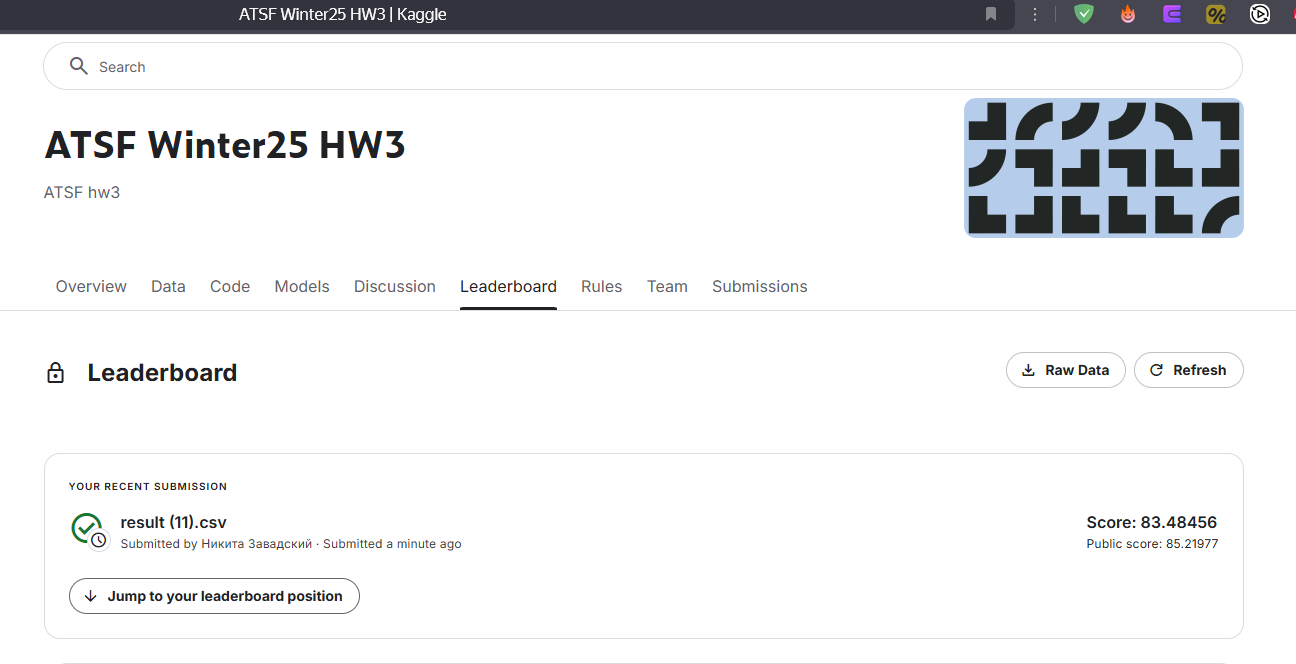